In [ ]:
# Installing the Backtrader Library
!pip install backtrader 

     |████████████████████████████████| 419kB 2.8MB/s 


In [ ]:
# Importing the required packages
from __future__ import (absolute_import, division, print_function, unicode_literals)

import warnings
warnings.filterwarnings('ignore')

import datetime # for datetime information
import os.path  # to manage paths
import sys      # to find out the script name (in argv[0])

import backtrader as bt # Importing the Backtrader library 

In [ ]:
# Coding the strategy

class SMA_strategy(bt.Strategy):
    params = (('maperiod', 15),)

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt)) 

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.SMA_strategy = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy(): # Buy
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending; if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.SMA_strategy[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.SMA_strategy[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 10000.00
2018-01-23, Close, 42.67
2018-01-23, BUY CREATE, 42.67
2018-01-24, BUY EXECUTED, Price: 42.72, Cost: 4272.00, Comm 0.00
2018-01-24, Close, 41.99
2018-01-24, SELL CREATE, 41.99
2018-01-25, SELL EXECUTED, Price: 42.06, Cost: 4272.00, Comm 0.00
2018-01-25, OPERATION PROFIT, GROSS -66.00, NET -66.00
2018-01-25, Close, 41.24
2018-01-26, Close, 41.33
2018-01-29, Close, 40.48
2018-01-30, Close, 40.24
2018-01-31, Close, 40.35
2018-02-01, Close, 40.43
2018-02-02, Close, 38.68
2018-02-05, Close, 37.71
2018-02-06, Close, 39.29
2018-02-07, Close, 38.45
2018-02-08, Close, 37.39
2018-02-09, Close, 37.85
2018-02-12, Close, 39.37
2018-02-13, Close, 39.77
2018-02-13, BUY CREATE, 39.77
2018-02-14, BUY EXECUTED, Price: 39.45, Cost: 3945.00, Comm 0.00
2018-02-14, Close, 40.50
2018-02-15, Close, 41.86
2018-02-16, Close, 41.72
2018-02-20, Close, 41.58
2018-02-21, Close, 41.39
2018-02-22, Close, 41.74
2018-02-23, Close, 42.47
2018-02-26, Close, 43.31
2018-02-27, Close, 43.1

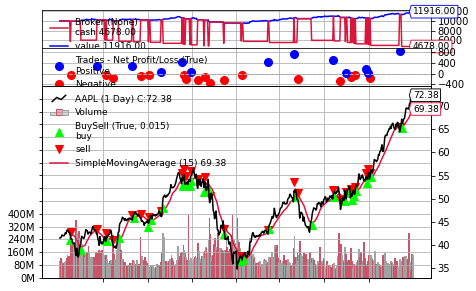

In [ ]:
# SMA - Simple Moving Average Indicator

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(SMA_strategy)

        # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname='AAPL',
        fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2019, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(iplot=False)